# Random Forest Regression

In [36]:
# reoder variables to work on train or test dataset
#predict_for_submission = True
predict_for_submission = False

tune_parameters = True

In [37]:
from import_man import *


%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

Loading dataset:

In [38]:
df = pd.read_csv('dataset/preprocessed_train_PCA.csv')

if predict_for_submission:
    df_test = pd.read_csv('dataset/preprocessed_test_PCA.csv')

In [39]:
print('(examples,columns)')
df.shape

(examples,columns)


(433958, 45)

selecting useful features:

In [40]:
df = df.drop(['NumberOfCustomers'], axis=1)
print('Since we do not have NumberOfCustomers attribute in the test set, we drop it.')

Since we do not have NumberOfCustomers attribute in the test set, we drop it.


In [41]:
print('Categorical attributes are dropped because we consider for the analysis the "One Hot Encoding" version.')
df = df.drop(['Unnamed: 0','StoreType','AssortmentType','D_DayOfweek'], axis=1)
if predict_for_submission:
    df_test = df_test.drop(['Unnamed: 0','StoreType','AssortmentType','D_DayOfweek'], axis=1)

Categorical attributes are dropped because we consider for the analysis the "One Hot Encoding" version.


### Attributes kept:

In [42]:
df.head().T

,0,1,2,3,4
StoreID,1000,1000,1000,1000,1000
Date,01/03/2016,02/03/2016,04/03/2016,05/03/2016,07/03/2016
IsHoliday,0,0,0,0,0
HasPromotions,0,0,0,0,1
NearestCompetitor,326,326,326,326,326
Region,7,7,7,7,7
NumberOfSales,5676,8111,8300,7154,10110
Region_AreaKM2,9643,9643,9643,9643,9643
Region_GDP,17130,17130,17130,17130,17130
Region_PopulationK,2770,2770,2770,2770,2770


In [43]:
df.shape

(433958, 40)

In [44]:
df_test.shape

(37586, 40)

In [45]:
if predict_for_submission:
    print(set(df.columns)-set(df_test.columns))

The attributes identified by "px" where x goes from 1 to 12 are the components obtained performing PCA on several attributes. 
You can check the whole PCA notebook looking at "3.4_Prepr_train_PCA".

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

Loading train and test set:

In [47]:
import modify_dataset as md

if predict_for_submission:
    train = df
    test = df_test
else:
    test_months = (3, 4)
    test_year = 2017

    train = md.get_fake_train(df, test_months, test_year)
    test = md.get_fake_test(df, test_months, test_year)

print('df.shape    ', df.shape)
print('train.shape ', train.shape)
print('test.shape  ', test.shape)

y_train = train['NumberOfSales']

df.shape     (433958, 40)
train.shape  (396420, 40)
test.shape   (37538, 40)


# Feature selection on the train set:

In [48]:
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
features.remove('Date')

features.remove('AssortmentType_WithFishDept')
features.remove('StoreType_ShoppingCenter')
features.remove('StoreType_StandardMarket')
features.remove('AssortmentType_General')
features.remove('CloudCover')
features.remove('MeanRegionSales')
features.remove('AssortmentType_WithNFDept')
features.remove('IsHoliday')
features.remove('StoreType_SuperMarket')
features.remove('MeanRegionCustomers')


print("features")

pprint(sorted(features))
print(len(features))

features
['D_Day',
 'D_DayOfWeek_cos',
 'D_DayOfWeek_sin',
 'D_DayOfYear',
 'D_Month',
 'D_Year',
 'HasPromotions',
 'MeanCustomers',
 'MeanStoreSales',
 'NearestCompetitor',
 'Region',
 'Region_AreaKM2',
 'Region_GDP',
 'Region_PopulationK',
 'StoreType_HyperMarket',
 'p1',
 'p10',
 'p11',
 'p12',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9']
27


In [49]:
train.shape

(396420, 40)

In [50]:
train[features].head().T

,0,1,2,3,4
HasPromotions,0.000000,0.000000,0.000000,0.000000,1.000000
NearestCompetitor,326.000000,326.000000,326.000000,326.000000,326.000000
Region,7.000000,7.000000,7.000000,7.000000,7.000000
Region_AreaKM2,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
Region_GDP,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000
Region_PopulationK,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000
D_Day,1.000000,2.000000,4.000000,5.000000,7.000000
D_DayOfYear,61.000000,62.000000,64.000000,65.000000,67.000000
D_Month,3.000000,3.000000,3.000000,3.000000,3.000000
D_Year,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000


# Random Forest parameters tuning

n_estimators analysis: 

In [16]:
params = range(1, 101, 10)  #50,201,50

In [17]:
if tune_parameters:
    from sklearn.ensemble import RandomForestRegressor
    scores, tst_scr = validation_curve(RandomForestRegressor(), train[features][:20000],\
                                       y_train[:20000], 'n_estimators', params, \
                                       cv=5, scoring='r2',n_jobs=-1, verbose=2)

[CV] n_estimators=1 ..................................................
[CV] n_estimators=11 .................................................
[CV] n_estimators=21 .................................................
[CV] n_estimators=31 .................................................
[CV] ................................... n_estimators=1, total=   0.4s
[CV] n_estimators=41 .................................................
[CV] .................................. n_estimators=11, total=   3.2s
[CV] n_estimators=51 .................................................
[CV] .................................. n_estimators=21, total=   6.0s
[CV] n_estimators=61 .................................................
[CV] .................................. n_estimators=31, total=   8.8s
[CV] n_estimators=71 .................................................
[CV] .................................. n_estimators=41, total=  11.6s
[CV] n_estimators=81 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  1.3min remaining:  1.3min


[CV] .................................. n_estimators=51, total=  14.4s
[CV] n_estimators=91 .................................................
[CV] .................................. n_estimators=61, total=  17.3s
[CV] n_estimators=1 ..................................................
[CV] ................................... n_estimators=1, total=   0.3s
[CV] n_estimators=11 .................................................
[CV] .................................. n_estimators=11, total=   3.1s
[CV] n_estimators=21 .................................................
[CV] .................................. n_estimators=71, total=  20.1s
[CV] n_estimators=31 .................................................
[CV] .................................. n_estimators=81, total=  22.8s
[CV] n_estimators=41 .................................................
[CV] .................................. n_estimators=21, total=   6.0s
[CV] n_estimators=51 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.9min finished


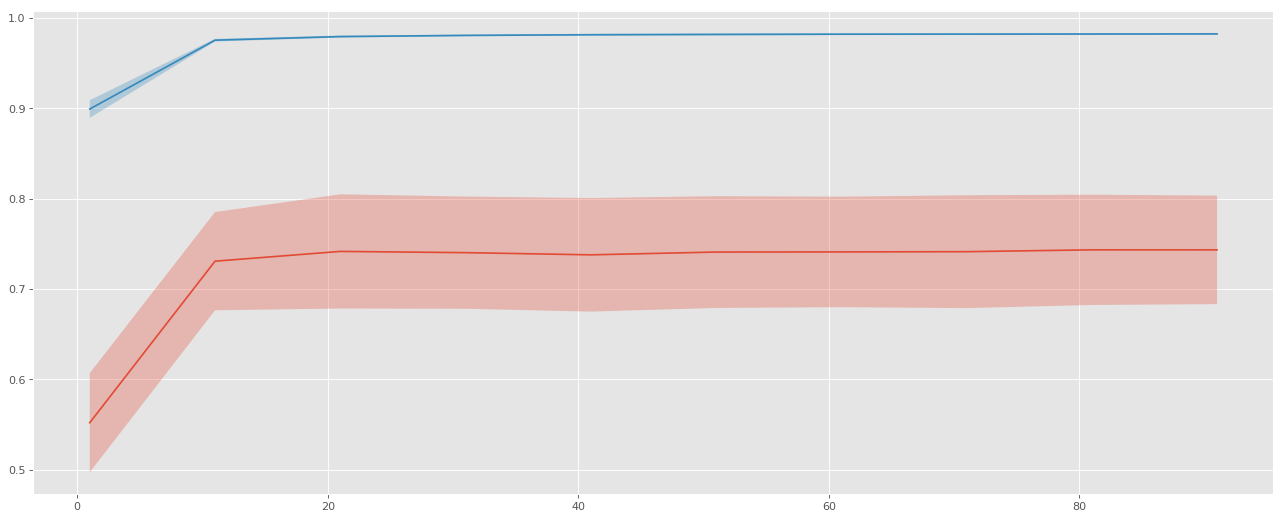

In [18]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

if tune_parameters:
    scores_mean = scores.mean(axis=1)
    scores_std = scores.std(axis=1)
    tst_scr_mean = tst_scr.mean(axis=1)
    tst_scr_std = tst_scr.std(axis=1)
    plt.plot(params, tst_scr_mean)
    plt.fill_between(params, tst_scr_mean + tst_scr_std, tst_scr_mean - tst_scr_std, alpha=0.3)
    plt.plot(params, scores_mean)
    plt.fill_between(params, scores_mean + scores_std, scores_mean - scores_std, alpha=0.3)

As we can see in the graph, from 40 estimators on the performance curve is stable, so we set n_estimators = 40. 

##### 

max_features analysis:

In [19]:
params = range(1, 25,2)

In [20]:
if tune_parameters:
    from sklearn.ensemble import RandomForestRegressor
    scores, tst_scr = validation_curve(RandomForestRegressor(n_estimators=10), train[features][:20000], \
                                       y_train[:20000], 'max_features', params, \
                                       cv=3, scoring='r2',n_jobs=-1, verbose=2)

[CV] max_features=1 ..................................................
[CV] max_features=3 ..................................................
[CV] max_features=5 ..................................................
[CV] max_features=7 ..................................................
[CV] ................................... max_features=1, total=   0.3s
[CV] max_features=9 ..................................................
[CV] ................................... max_features=3, total=   0.5s
[CV] max_features=11 .................................................
[CV] ................................... max_features=5, total=   0.6s
[CV] max_features=13 .................................................
[CV] ................................... max_features=7, total=   0.8s
[CV] max_features=15 .................................................
[CV] ................................... max_features=9, total=   1.0s
[CV] max_features=17 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  18 out of  36 | elapsed:    5.4s remaining:    5.4s


[CV] .................................. max_features=13, total=   1.2s
[CV] max_features=21 .................................................
[CV] .................................. max_features=15, total=   1.4s
[CV] max_features=23 .................................................
[CV] .................................. max_features=17, total=   1.5s
[CV] max_features=1 ..................................................
[CV] ................................... max_features=1, total=   0.2s
[CV] max_features=3 ..................................................
[CV] .................................. max_features=19, total=   1.7s
[CV] max_features=5 ..................................................
[CV] ................................... max_features=3, total=   0.4s
[CV] max_features=7 ..................................................
[CV] ................................... max_features=5, total=   0.6s
[CV] max_features=9 ..................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   12.0s finished


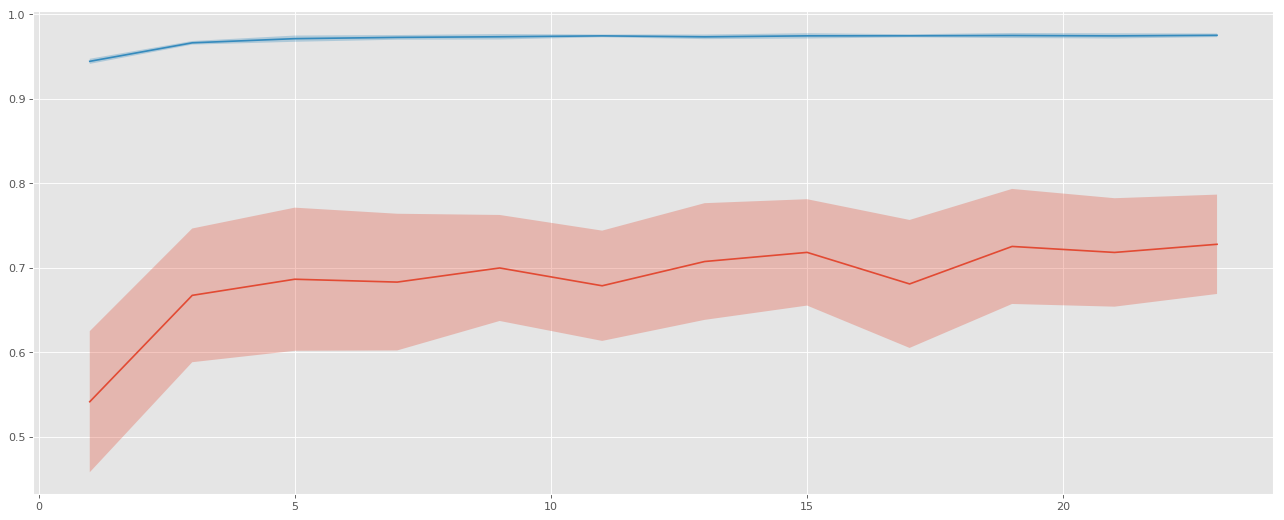

In [21]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

if tune_parameters:
    scores_mean = scores.mean(axis=1)
    scores_std = scores.std(axis=1)
    tst_scr_mean = tst_scr.mean(axis=1)
    tst_scr_std = tst_scr.std(axis=1)
    plt.plot(params, tst_scr_mean)
    plt.fill_between(params, tst_scr_mean + tst_scr_std, tst_scr_mean - tst_scr_std, alpha=0.3)
    plt.plot(params, scores_mean)
    plt.fill_between(params, scores_mean + scores_std, scores_mean - scores_std, alpha=0.3)

As we can see in the chart above, it seems that more than 20 features can ensure the best performances.

max_depth analysis:

In [22]:
params = range(5, 101, 5)

In [23]:
if tune_parameters:
    from sklearn.ensemble import RandomForestRegressor
    scores, tst_scr = validation_curve(RandomForestRegressor(n_estimators=100), train[features][:20000], \
                                       y_train[:20000], 'max_depth', params, \
                                       cv=3, scoring='r2',n_jobs=-1, verbose=2)

[CV] max_depth=5 .....................................................
[CV] max_depth=10 ....................................................
[CV] max_depth=15 ....................................................
[CV] max_depth=20 ....................................................
[CV] ...................................... max_depth=5, total=   8.0s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=10, total=  15.6s
[CV] max_depth=30 ....................................................
[CV] ..................................... max_depth=15, total=  21.0s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=20, total=  23.8s
[CV] max_depth=40 ....................................................
[CV] ..................................... max_depth=25, total=  24.5s
[CV] max_depth=45 ....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  30 out of  60 | elapsed:  2.9min remaining:  2.9min


[CV] ..................................... max_depth=55, total=  23.3s
[CV] max_depth=75 ....................................................
[CV] ..................................... max_depth=60, total=  23.4s
[CV] max_depth=80 ....................................................
[CV] ..................................... max_depth=65, total=  23.6s
[CV] max_depth=85 ....................................................
[CV] ..................................... max_depth=70, total=  23.5s
[CV] max_depth=90 ....................................................
[CV] ..................................... max_depth=75, total=  23.4s
[CV] max_depth=95 ....................................................
[CV] ..................................... max_depth=80, total=  23.6s
[CV] max_depth=100 ...................................................
[CV] ..................................... max_depth=85, total=  23.7s
[CV] max_depth=5 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.7min finished


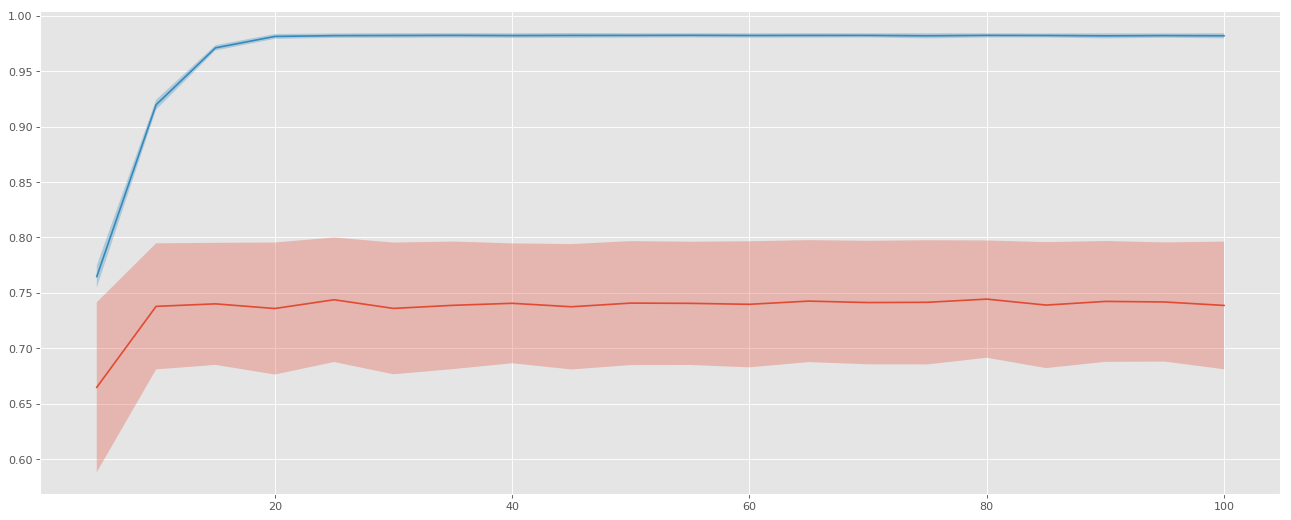

In [24]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

if tune_parameters:
    scores_mean = scores.mean(axis=1)
    scores_std = scores.std(axis=1)
    tst_scr_mean = tst_scr.mean(axis=1)
    tst_scr_std = tst_scr.std(axis=1)
    plt.plot(params, tst_scr_mean)
    plt.fill_between(params, tst_scr_mean + tst_scr_std, tst_scr_mean - tst_scr_std, alpha=0.3)
    plt.plot(params, scores_mean)
    plt.fill_between(params, scores_mean + scores_std, scores_mean - scores_std, alpha=0.3)

The graph above show how a suitable value for max_depth is 20, indeed even increasing it, the performance are stable.

# Model Building 

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
model1 = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, verbose=2)

In [53]:
model1.fit(train[features], train['NumberOfSales'])

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

Which are the most relevant features?

In [54]:
idx = model1.feature_importances_.argsort()[::-1]

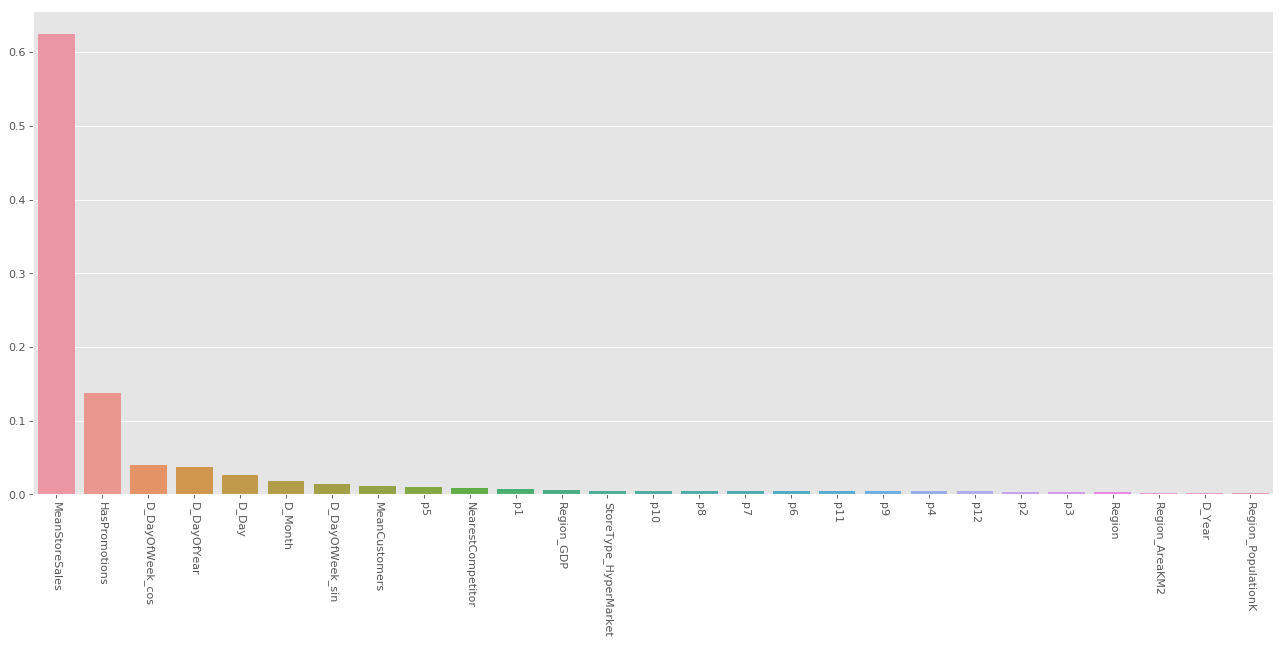

In [55]:
ax = sns.barplot(x=df[features].columns[idx], y=model1.feature_importances_[idx])
_ = plt.setp(ax.get_xticklabels(), rotation=-90)

# Predict

In [56]:
test['_NumberOfSales'] = model1.predict(test[features])

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


In [57]:
train['_NumberOfSales'] = model1.predict(train[features])

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


# Estimating error through BIP function

In [58]:
if not predict_for_submission:
    from BIP import get_BIP_error
    error1 = get_BIP_error(test)

BIP total error: 0.03911885243358792


In [59]:
if not predict_for_submission:
    from BIP import get_BIP_error
    error1 = get_BIP_error(train)

BIP total error: 0.015398213669341927


## Writing to file

In [60]:
if predict_for_submission:
    test.to_csv('./dataset/submission_53_RFR_on_prep.csv', index=False)
else:
    mm = 'm{}{}'.format(test_months[0],test_months[1])
    test.to_csv('./dataset/test_'+mm+'_53_RFR_on_prep.csv', index=False)

# Estimating error through R2 function

In [61]:
# calculationg R2

# calculate RSS
df_RSS = test
print(df_RSS.shape)

df_RSS['sqrd_diff'] = df_RSS.apply(lambda x: (x['NumberOfSales'] - x['_NumberOfSales'])**2, axis=1)

RSS = df_RSS['sqrd_diff'].sum()
print('RSS:', RSS)
df_RSS.head()

(37538, 41)
RSS: 22993660105.026287


,StoreID,Date,IsHoliday,HasPromotions,NearestCompetitor,Region,NumberOfSales,Region_AreaKM2,Region_GDP,Region_PopulationK,...,p5,p6,p7,p8,p9,p10,p11,p12,_NumberOfSales,sqrd_diff
302,1000,01/03/2017,0,0,326,7,5509,9643,17130,2770,...,0.002268,0.000889,0.000052,-0.000992,-0.000124,-0.000808,-0.000501,0.000075,6642.490219,1.284800e+06
303,1000,02/03/2017,0,0,326,7,5881,9643,17130,2770,...,0.002234,0.001760,-0.000015,-0.000700,0.000316,-0.000881,-0.000139,0.000136,7645.940786,3.115016e+06
304,1000,03/03/2017,0,0,326,7,8463,9643,17130,2770,...,0.002211,0.000456,-0.000833,-0.000546,-0.000316,-0.000455,-0.000162,-0.000145,7996.720086,2.174170e+05
305,1000,04/03/2017,0,0,326,7,8146,9643,17130,2770,...,0.002251,0.000720,-0.000274,-0.001242,-0.000021,-0.000516,-0.000457,0.000222,7621.263690,2.753482e+05
306,1000,06/03/2017,0,1,326,7,11306,9643,17130,2770,...,0.002208,0.000525,-0.001188,-0.000629,-0.000746,-0.000432,0.000514,0.000050,10619.408745,4.714076e+05


In [62]:
# calculate TSS

df_TSS = test
NS_mean = df_TSS['NumberOfSales'].mean()
print('NS_mean', NS_mean)

df_TSS['sqrd_diff'] = df_TSS.apply(lambda x:  (x['_NumberOfSales'] - NS_mean)**2, axis=1)
TSS = df_TSS['sqrd_diff'].sum()
print('TSS:', TSS)
df_TSS.head()

NS_mean 4725.085193670414
TSS: 150828839570.88092


,StoreID,Date,IsHoliday,HasPromotions,NearestCompetitor,Region,NumberOfSales,Region_AreaKM2,Region_GDP,Region_PopulationK,...,p5,p6,p7,p8,p9,p10,p11,p12,_NumberOfSales,sqrd_diff
302,1000,01/03/2017,0,0,326,7,5509,9643,17130,2770,...,0.002268,0.000889,0.000052,-0.000992,-0.000124,-0.000808,-0.000501,0.000075,6642.490219,3.676442e+06
303,1000,02/03/2017,0,0,326,7,5881,9643,17130,2770,...,0.002234,0.001760,-0.000015,-0.000700,0.000316,-0.000881,-0.000139,0.000136,7645.940786,8.531397e+06
304,1000,03/03/2017,0,0,326,7,8463,9643,17130,2770,...,0.002211,0.000456,-0.000833,-0.000546,-0.000316,-0.000455,-0.000162,-0.000145,7996.720086,1.070359e+07
305,1000,04/03/2017,0,0,326,7,8146,9643,17130,2770,...,0.002251,0.000720,-0.000274,-0.001242,-0.000021,-0.000516,-0.000457,0.000222,7621.263690,8.387850e+06
306,1000,06/03/2017,0,1,326,7,11306,9643,17130,2770,...,0.002208,0.000525,-0.001188,-0.000629,-0.000746,-0.000432,0.000514,0.000050,10619.408745,3.474305e+07


In [63]:
# calculate R2
print("RSS:", RSS, "   TSS:", TSS)

R2 = 1 - (RSS / TSS)
print('R_2:', R2)


RSS: 22993660105.026287    TSS: 150828839570.88092
R_2: 0.8475513027187311


## Sample of predicted results

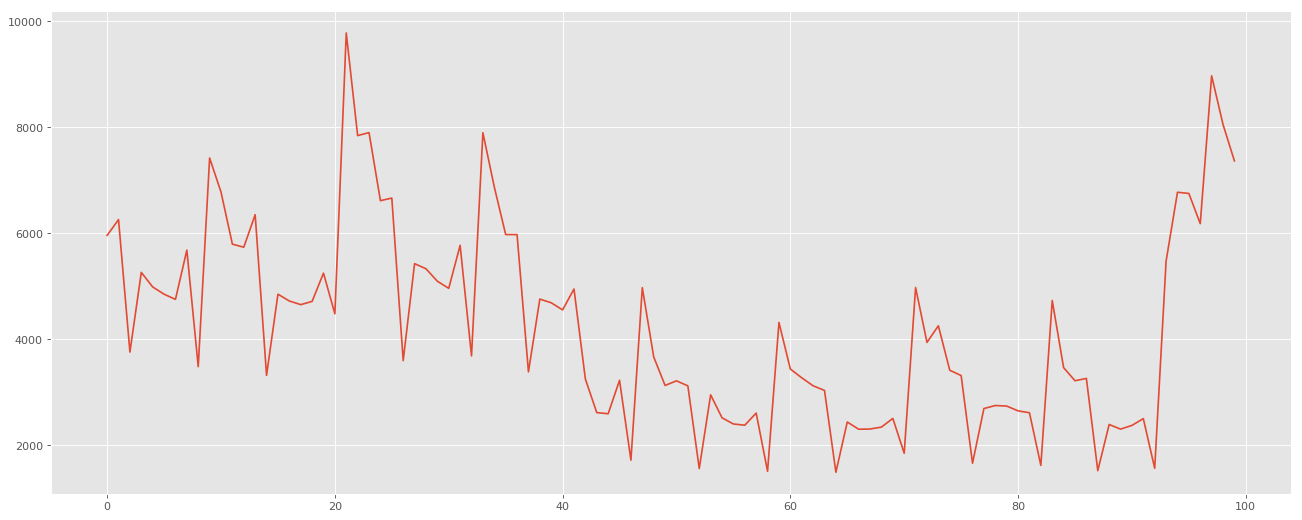

In [64]:
import matplotlib.pyplot as plt

y_pred_subset = test['_NumberOfSales'][500:600]
x_coordinate = [ 1 * i for i in range(len(y_pred_subset)) ]
plt.plot(x_coordinate,y_pred_subset)
plt.show()

## Sample of real results

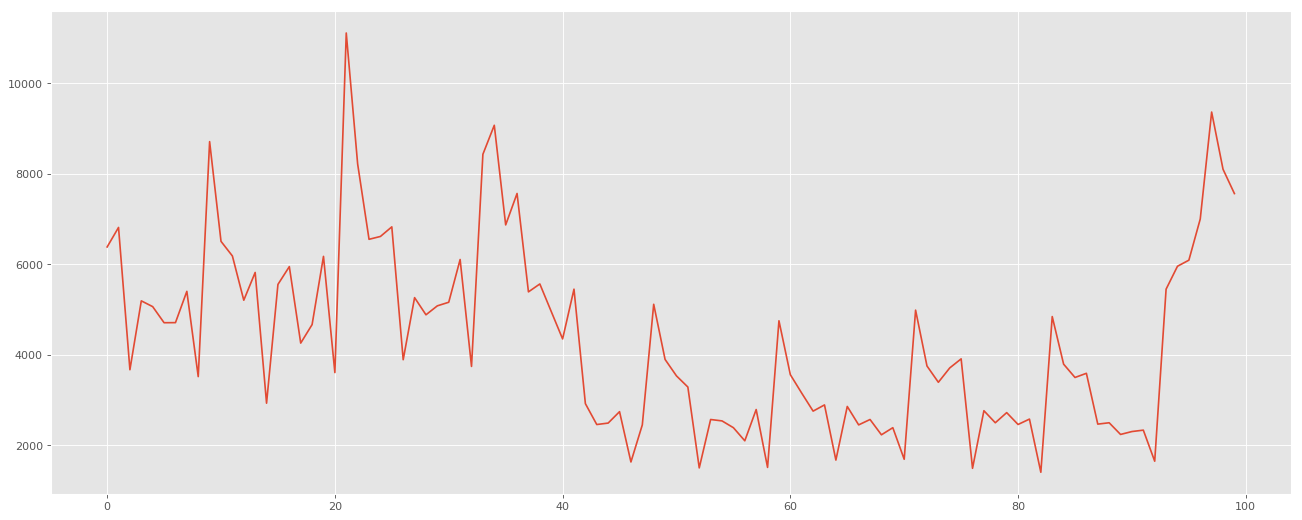

In [65]:
#REAL
import matplotlib.pyplot as plt

y_train_subset = test['NumberOfSales'][500:600]
x_coordinate = [ 1 * i for i in range(len(y_train_subset)) ]
plt.plot(x_coordinate,y_train_subset)
plt.show()

## Real-Predicted

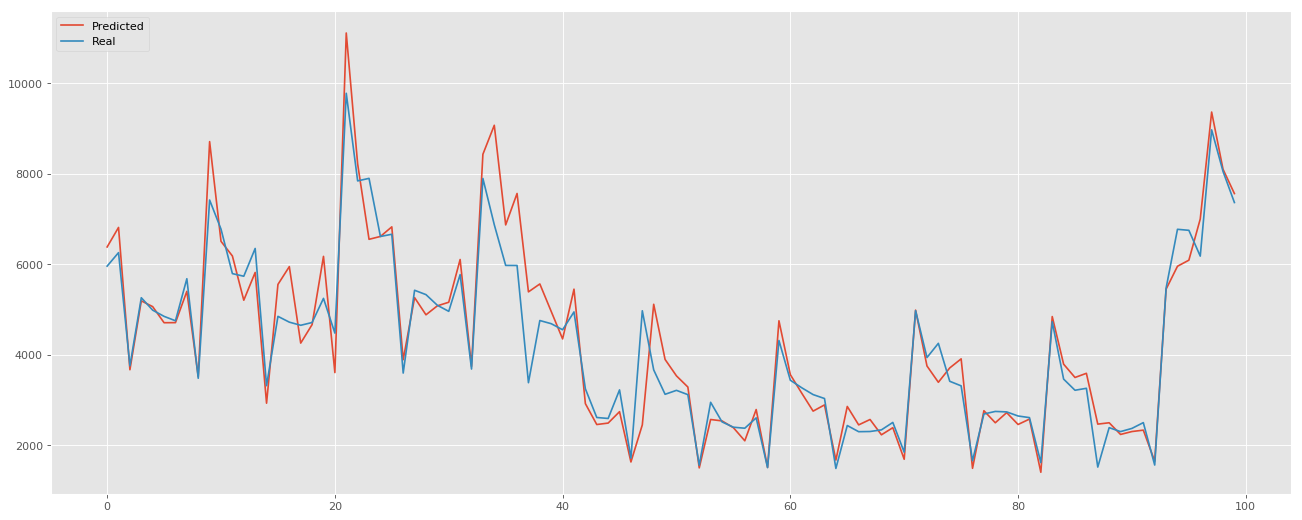

In [66]:
plt.plot(x_coordinate,y_train_subset)
plt.plot(x_coordinate,y_pred_subset)

plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()